Approach 2, second try:
- Scientist receives conversation. 
- Goes through the conversational flow.
- Queries the graph.
- Save query in history of queries. 
- Save Query results in history of query results. 
- ToolMessage is not saved in conversation messages.
- Have a variable for the extracted occupations or traits.

In [11]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# LangSmith
from langsmith import traceable

# General Imports
import os
import ast
import prompts
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

# Connect to graph
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('NEO4J_URI')
os.environ["NEO4J_USERNAME"] = os.getenv('NEO4J_USERNAME')
os.environ["NEO4J_PASSWORD"] = os.getenv('NEO4J_PASSWORD')
graph = Neo4jGraph()

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)

# Create Agent's State
class AgentState(TypedDict):
    conversation: Annotated[list[ AnyMessage ], operator.add]
    good_cypher_and_outputs: Annotated[dict[ str, str ], operator.or_]
    bad_cypher: Annotated[list[ str ], operator.add]
    extracted_data: Annotated[list[ str ], operator.add]

    graph_data_to_be_used: list[str]

# Create Agent
class Agent:

    def __init__(self, model, tools, system: str):

        graph = StateGraph(AgentState)
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq)
        graph.add_node("validate_cypher_then_query_graph", self.validate_cypher_then_query_graph) # Checks if query is new
        graph.add_node("extract_data", self.extract_data)
        graph.add_node("recommend_careers", self.recommend_careers)

        graph.add_conditional_edges("personality_scientist", self.validate_tool_call, {True: 'validate_cypher_then_query_graph', False: END})
        graph.add_conditional_edges("recommend_careers", self.validate_tool_call, {True: 'validate_cypher_then_query_graph', False: END})
        graph.add_edge("validate_cypher_then_query_graph", "extract_data")
        graph.add_edge("extract_data", "recommend_careers")
        graph.set_entry_point("personality_scientist")

        self.graph = graph.compile(checkpointer=memory)
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools)

    ## Helper function that returns the cyphers written before. This is used when calling the LLM
    def get_previous_cyphers(self, state: AgentState):
        cyphers_list = ""
        
        if len(state['bad_cypher']) > 0:
            cyphers_list += f"- Here are previously written cypher codes that did not return an output: {str(state['bad_cypher'])}"

        good_cypher = list(state['good_cypher_and_outputs'].keys())
        if len(good_cypher) > 0:
            cyphers_list += f"- Here are previously written cypher codes that successfully returned an output: {str(good_cypher)}"
        
        if cyphers_list != "": 
            output = "\nWhen you are ready to write the cypher code, use these as reference: \n" + cyphers_list
            return output
        else:
            return None
    
    ## Get the LLM's response and update the Agent's State by adding the response to the messages
    @traceable
    def call_groq(self, state: AgentState):

        previous_cyphers = self.get_previous_cyphers(state = state)
        if previous_cyphers:
            system_message = f"{self.system}. {previous_cyphers}"
        else:
            system_message = self.system

        conversation = [SystemMessage(content=system_message)] + state['conversation']
        ai_response = self.model.invoke(conversation)

        return {'conversation': [ai_response]}

    ## Check if the model called for an action by checking the last message in the conversation
    def validate_tool_call(self, state: AgentState):
        ai_message = state['conversation'][-1]
        return len(ai_message.tool_calls) > 0
        
    ## Check if the new cypher codes have already been written by the LLM
    def validate_cypher_then_query_graph(self, state: AgentState):
        print(f"\n------- in validate query")
        tool_calls = state['conversation'][-1].tool_calls

        good_cypher_and_outputs = {} # stores the cypher queries that returned an output
        bad_cypher = [] # stores the cypher queries that did not return an output
        graph_data_to_be_used = [] # stores the queries that the model currently wants to use

        # Go over the cypher codes given by the LLM
        for i in range(len(tool_calls)):
            current_tool_call = tool_calls[i]
            new_cypher = current_tool_call['args']['query']

            status = None

            # Check if tool exists
            if current_tool_call['name'] in self.tools:
                
                # LLM checks if the cypher query has already been made + if it returned an output
                if status == None:
                    print(f"----- Checker 1")
                    good_cyphers = list(state['good_cypher_and_outputs'].keys())
                    for i in range(len( good_cyphers )):
                        key = good_cyphers[i]
                        comparison = self.model.invoke(
                            prompts.cypher_code_analyst_prompt.format(cypher_code_1=new_cypher, cypher_code_2=key, graph_schema=graph.structured_schema)
                            )
                        print(f"\n-------- {comparison.content}")
                        # If Query exists => Save cypher code to later access the output and give it to the model
                        if comparison.content.lower() == "true":
                            print("\n----- Good Cyphers are similar, save the cypher")
                            graph_data_to_be_used.append(key)
                            status = "good_cypher"
                            break
                
                # LLM checks if the cypher query has already been made + if it didn't return an output
                if status == None:
                    print(f"----- Checker 2")
                    for i in range(len(state['bad_cypher'])):
                        comparison = self.model.invoke(
                            prompts.cypher_code_analyst_prompt.format(
                                cypher_code_1=new_cypher, cypher_code_2=state['bad_cypher'][i], graph_schema=graph.structured_schema)
                            )
                        # Query exists => LLM should fix the query
                        if comparison.content.lower() == "true":
                            print("---- Bad Cyphers are similar, have the LLM query again")
                            status = "bad_cypher"
                            break

                # If the cypher code hasn't been used before => query the graph
                if status == None:
                    print(f"----- Checker 3")
                    query_output = self.tools[current_tool_call['name']].invoke(new_cypher)
                    result = ToolMessage(content=str(query_output), name=current_tool_call['name'], tool_call_id=current_tool_call['id'])
                    
                    if result.content not in ["", None, '[]']:
                        good_cypher_and_outputs[new_cypher] = result.content
                        graph_data_to_be_used.append(new_cypher)
                        print("----- Successfully queried graph")

                    else:
                        bad_cypher.append(new_cypher)
                        print("----- Bad query")
            else:
                print("tool name not found in list of tools")

        # Save the data that we got in the AgentState
        return_statement = {}
        if len(good_cypher_and_outputs) > 0: return_statement['good_cypher_and_outputs'] = good_cypher_and_outputs
        if len(bad_cypher) > 0: return_statement['bad_cypher'] = bad_cypher
        if len(graph_data_to_be_used) > 0: return_statement['graph_data_to_be_used'] = graph_data_to_be_used

        return return_statement
    
    ## LLM extracts what it needs from the query's output
    def extract_data(self, state: AgentState):
        print('\n-------> In extract data')

        if len(state['graph_data_to_be_used']) > 0:
            data_to_give_to_the_LLM = [{cypher: state['good_cypher_and_outputs'][cypher]} for cypher in state['graph_data_to_be_used']]
            extracted_data = self.model.invoke(
                prompts.extractor_prompt.format(queried_data = data_to_give_to_the_LLM, conversation = state['conversation'])
                )
            print("----- Data has been extracted")
            return {'extracted_data': [extracted_data.content]}

        else:
            print("No queries to be made")
            return

    ## Generate final output
    def recommend_careers(self, state: AgentState):

        # Give the LLM context of previously written cypher code
        previous_cyphers = self.get_previous_cyphers(state = state)
        if previous_cyphers:
            system_message = f"{self.system}. {previous_cyphers}"
        else:
            system_message = self.system
        
        conversation = [SystemMessage(content=system_message)] + state['conversation']

        # Give LLM a prompt based on the data received from the graph. (Data received can be empty or not)
        if len(state['graph_data_to_be_used']) > 0:
            prompt = conversation + [HumanMessage(content= prompts.recommender_prompt_with_data.format(extracted_data=state['extracted_data'][-1]))]
            print("----- Giving extracted data to the agent")
        else:
            prompt = conversation + [HumanMessage(content= prompts.recommender_prompt_without_data)]
            print("----- No data to give to the agent")
        
        ai_response = self.model.invoke(prompt)
        print("------- Ready to recommend")
        return {'conversation': [ai_response]}

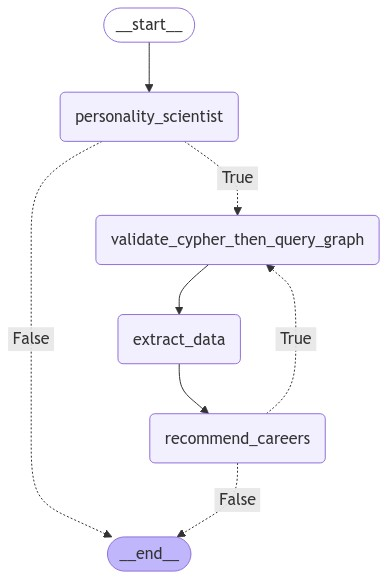

In [12]:
model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile", max_retries=2)
# model = ChatGroq(temperature=0.0, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")

agent = Agent(
  model=model, 
  tools=[query_graph], 
  system=prompts.personality_scientist_prompt.format(schema=graph.structured_schema)
  )

graph_png = Image(agent.graph.get_graph().draw_mermaid_png())
display(graph_png)

In [ ]:
thread = {'configurable': {'thread_id': "100"}}
output = agent.graph.stream({"conversation": [HumanMessage(content="try to analyze it from different angles to find a logical solution")], 'graph_data_to_be_used': []}, thread, stream_mode='values')

for message in output:
    message['conversation'][-1].pretty_print()

In [ ]:
state = agent.graph.get_state(thread).values
state

In [6]:
import streamlit as st
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

In [ ]:
def display_knowledge_graph(data):
    head = []
    tail = []

    # Extract head and tail nodes
    for i in range(len(data)):
        row = data[i]
        keys = list(row.keys())
        node_1 = row[keys[0]]['title']
        node_2 = row[keys[1]]['title']

        head.append(node_1)
        tail.append(node_2)

    # Create a DataFrame
    df = pd.DataFrame({'head': head, 'tail': tail})

    # Create the graph
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['head'], row['tail'], label="")

    # Get positions for nodes
    pos = nx.fruchterman_reingold_layout(G, k=0.7)

    # Create edge traces (lines between nodes)
    edge_traces = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=0.3, color='gray'),
            hoverinfo='none'
        )
        edge_traces.append(edge_trace)

    # Assign colors based on whether the node is in the head or tail
    node_colors = []
    for node in G.nodes():
        if node in head:
            node_colors.append('lightblue')  # Color for head nodes (node_1)
        elif node in tail:
            node_colors.append('lightcoral')   # Color for tail nodes (node_2)
        else:
            node_colors.append('gold')  # Default color

    # Create node trace (nodes with their respective colors)
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        mode='markers+text',
        marker=dict(size=10, color=node_colors),  # Use node_colors list for colors
        text=[node for node in G.nodes()],
        textposition='top center',
        hoverinfo='text',
        textfont=dict(size=7)
    )

    # Create edge label trace (optional, for labeling edges)
    edge_label_trace = go.Scatter(
        x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in G.edges()],
        y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in G.edges()],
        mode='text',
        text=[G[edge[0]][edge[1]]['label'] for edge in G.edges()],
        textposition='middle center',
        hoverinfo='none',
        textfont=dict(size=7)
    )

    # Create layout
    layout = go.Layout(
        title='',
        titlefont_size=16,
        title_x=0.5,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis_visible=False,
        yaxis_visible=False
    )

    # Create Plotly figure
    fig = go.Figure(data=edge_traces + [node_trace, edge_label_trace], layout=layout)

    return fig


# for i in range(len(state['graph_data_to_be_used'])):
g = ast.literal_eval(state['good_cypher_and_outputs']['MATCH (n:Occupation)-[]->(m:Personality_Trait) RETURN n, m'])
# display_knowledge_graph(g)
g 